## Setup

In [1]:
import MEArec as mr
import numpy as np
import scipy.optimize
import os
import sys
import re
import ast
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import pandas as pd
import pickle
import time 
from collections import defaultdict
from joblib import Parallel, delayed

import spikeinterface as si
import spikeinterface.core as sc
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
import spikeinterface.comparison as scomp
import spikeinterface.curation as scu

sys.path.append('src')
from src.util_eval import *
from src.util_loc import *

In [2]:
# Overall parameters
dead_indices_seeds = [42, 43, 44, 45, 46]
run_id = '20251028'
sorter_name = 'mountainsort4'
days = ['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']
methods = ['center_of_mass', 'monopolar_triangulation', 'grid_convolution']
stable_days = 1
dead_electrodes_per_day = 25
gt_toggle = 0
correct_radius = 50 # microns
num_channels = 384
spe1_duration = 300 # seconds

# SPE1 parameters
output_spe1 = f'output/{run_id}/spe1'
spe1_cells = ['c14', 'c15', 'c16', 'c19', 'c24', 'c26', 'c28', 'c29', 'c37', 'c45', 'c46']

In [3]:
data_summary = pd.read_excel(os.getcwd()+'/spe1/Data_Summary.xlsx')
spe1_npx_map = os.getcwd()+'/spe1/chanMap.mat'
spe1_data_folder = os.getcwd()+'/spe1/data'

d = scipy.io.loadmat(spe1_npx_map)
locations = np.zeros((384, 2))
locations[:, 0] = d['xcoords'][:, 0]
locations[:, 1] = d['ycoords'][:, 0]

/home/hao-zhao/anaconda3/envs/haozhao-si-0.100/lib/python3.8/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
for dead_indices_seed in dead_indices_seeds:
    output_spe1_seed = f'{output_spe1}/seed_{dead_indices_seed}'

    # Dead indices
    if os.path.exists(f'{output_spe1_seed}/dead_indices.pkl'):
        print('Loading dead indices')
        with open(f'{output_spe1_seed}/dead_indices.pkl', 'rb') as f:
            dead_indices = pickle.load(f)
    else:
        print('Creating dead indices')
        os.makedirs(output_spe1_seed)
        np.random.seed(dead_indices_seed)
        
        dead_indices = []
        dead_indices_temp = np.random.choice(range(num_channels), size=dead_electrodes_per_day*(len(days)-stable_days), replace=False)
        for day_i, day in enumerate(days):
            if day_i < stable_days:
                dead_indices.append([])
            else:
                dead_indices.append(dead_indices_temp[:dead_electrodes_per_day*(day_i-1)])
        
        with open(f'{output_spe1_seed}/dead_indices.pkl', "wb") as file:
            pickle.dump(dead_indices, file)
        
    # Load patch clamp and neuropixels data. Note 
    for spe1_cell in spe1_cells:
        spe1_npx_sample_rate = 30000

        # Determine paths
        spe1_cell_dir = f'{spe1_data_folder}/{spe1_cell}'
        paths = defaultdict(list)
        for file in os.listdir(spe1_cell_dir):
            if file.endswith('patch_ch1.bin'):
                paths['patch_v'].append(spe1_cell_dir + '/' + file) # patch-clamp current or voltage
            elif file.endswith('patch_sync.bin'):
                paths['patch_sync'].append(spe1_cell_dir + '/' + file) # patch-clamp sync channel
            elif file.endswith('npx_raw.bin'):
                paths['npx_v'].append(spe1_cell_dir + '/' + file) # neuropixel recording, 1D binary file
            elif file.endswith('npx_sync.bin'):
                paths['npx_sync'].append(spe1_cell_dir + '/' + file) # npx sync channel
            elif file.endswith('meta.csv'):
                paths['meta'].append(spe1_cell_dir + '/' + file) # dimensions that npx and patch-clamp files should be reshaped to and data type
            else:
                pass
        
        # Read files from paths
        spe1_meta = read_csv_1(paths['meta'][0])
        spe1_patch_v = np.fromfile(paths['patch_v'][0], dtype='float64')
        spe1_patch_sync = np.fromfile(paths['patch_sync'][0], dtype='float64') 
        spe1_npx_v = np.memmap(paths['npx_v'][0], dtype='int16', mode='r').reshape(-1, 384)
        spe1_npx_sync = np.fromfile(paths['npx_sync'][0], dtype='int16')

        # Calculate patch clamp spike indices and isolate first spe1_duration seconds
        spe1_spike_indices = detect_peak_on_patch_sig(spe1_patch_v, 50023)
        time_factor = spe1_npx_v.shape[0] / spe1_patch_v.shape[0]
        spe1_spike_indices = (spe1_spike_indices * time_factor).astype('int64')

        spe1_start_frame = 10 * spe1_npx_sample_rate
        spe1_end_frame = min(spe1_start_frame + spe1_npx_sample_rate*spe1_duration, spe1_npx_v.shape[0])
        
        spe1_spike_indices = spe1_spike_indices[np.logical_and(spe1_spike_indices > spe1_start_frame, spe1_spike_indices < spe1_end_frame)]
        spe1_spike_indices = spe1_spike_indices - spe1_start_frame

        for day_i, day in enumerate(days):        

            # Check if all required data already exists for this cell/day combination
            data_exists = (
                os.path.exists(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_units') and
                os.path.exists(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_spikes')
            )

            if data_exists:
                print(f'Skipping {spe1_cell}/{day} - all data already exists')
                continue
            
            # Recording
            recording_temp = se.BinaryRecordingExtractor(paths['npx_v'][0], spe1_npx_sample_rate, 'int16', num_channels=384)
            recording_temp = recording_temp.frame_slice(spe1_start_frame, spe1_end_frame)
            
            recording_temp.set_channel_locations(locations)
            recording_temp.set_property('gain_to_uV', np.ones(recording_temp.get_num_channels()) * 2.34375)
            recording_temp.set_property('offset_to_uV', np.zeros(recording_temp.get_num_channels()))

            get_recording_noise(recording_temp, dead_indices[day_i], f'{output_spe1_seed}/{spe1_cell}/{day}/recording')        
            spe1_recording = sc.load_extractor(f'{output_spe1_seed}/{spe1_cell}/{day}/recording')
            
            # Sorting
            spe1_sorting_gt = se.NumpySorting.from_times_labels(spe1_spike_indices, np.zeros(spe1_spike_indices.size, dtype='int64'), spe1_npx_sample_rate)
            se.NpzSortingExtractor.write_sorting(spe1_sorting_gt, f'{output_spe1_seed}/{spe1_cell}/{day}/sorting.npz')
            spe1_sorting_gt = se.NpzSortingExtractor(f'{output_spe1_seed}/{spe1_cell}/{day}/sorting.npz')            
            
            # Waveform extractors
            spe1_we_gt = si.extract_waveforms(spe1_recording, spe1_sorting_gt, folder=f'{output_spe1_seed}/{spe1_cell}/{day}/waveforms_gt', ms_before=1, ms_after=2)
            
            # Calculate template locations
            if os.path.exists(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_units'):
                print('Loading template localization estimates')
                with open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_units/loc_est_units.pkl', 'rb') as f:
                    loc_est_units = pickle.load(f)
                with open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_units/time_units.pkl', 'rb') as f:
                    time_units = pickle.load(f)
                    
            else:
                print('Calculating template localization estimates')            
                loc_est_units = {} # First entry is method
                time_units = {} # First entry is method

                for method in methods:

                    # Calculate the estimated location of templates
                    start_time = time.time()
                    if method == 'monopolar_triangulation':
                        unit_loc_est = spost.compute_unit_locations(spe1_we_gt, method=method, optimizer='least_square')
                    else:
                        unit_loc_est = spost.compute_unit_locations(spe1_we_gt, method=method)
                    time_units[method] = time.time() - start_time

                    loc_est_units[method] = unit_loc_est
                            
                os.makedirs(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_units')
                pickle.dump(loc_est_units, open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_units/loc_est_units.pkl', 'wb'))
                pickle.dump(time_units, open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_units/time_units.pkl', 'wb'))        

            # Calculate spike location estimates
            if os.path.exists(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_spikes'):
                print('Loading spike localization estimates')
                with open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_spikes/loc_est_spikes.pkl', 'rb') as f:
                    loc_est_spikes = pickle.load(f)
                with open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_spikes/time_spikes.pkl', 'rb') as f:
                    time_spikes = pickle.load(f)

            else:
                print('Calculating spike localization estimates')
                loc_est_spikes = {} # First entry is method
                time_spikes = {} # First entry is method

                for method in methods:
                
                    # Calculate the estimated location of the spikes
                    start_time = time.time()
                    if method == 'monopolar_triangulation':
                        spike_loc_est = spost.compute_spike_locations(spe1_we_gt, method=method, outputs='by_unit', method_kwargs={'optimizer': 'least_square'})
                    else:
                        spike_loc_est = spost.compute_spike_locations(spe1_we_gt, method=method, outputs='by_unit')
                    time_spikes[method] = time.time() - start_time

                    loc_est_spikes[method] = spike_loc_est
                                                
                os.makedirs(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_spikes')
                pickle.dump(loc_est_spikes, open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_spikes/loc_est_spikes.pkl', 'wb'))
                pickle.dump(time_spikes, open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_spikes/time_spikes.pkl', 'wb'))            
                    
            # Delete saved recording directory including all files
            os.system(f'rm -r {output_spe1_seed}/{spe1_cell}/{day}/recording')

Loading dead indices
Skipping c14/D0 - all data already exists
Skipping c14/D1 - all data already exists
Skipping c14/D2 - all data already exists
Skipping c14/D3 - all data already exists
Skipping c14/D4 - all data already exists
Skipping c14/D5 - all data already exists
Skipping c14/D6 - all data already exists
Skipping c14/D7 - all data already exists
Skipping c14/D8 - all data already exists
Skipping c14/D9 - all data already exists
Skipping c14/D10 - all data already exists
Skipping c14/D11 - all data already exists
Skipping c14/D12 - all data already exists
Skipping c14/D13 - all data already exists
Skipping c14/D14 - all data already exists
Skipping c14/D15 - all data already exists
Skipping c15/D0 - all data already exists
Skipping c15/D1 - all data already exists
Skipping c15/D2 - all data already exists
Skipping c15/D3 - all data already exists
Skipping c15/D4 - all data already exists
Skipping c15/D5 - all data already exists
Skipping c15/D6 - all data already exists
Skippin

## Figure Charts

In [5]:
fig_days = ['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']

fig_days_label = []
for day_i in range(len(fig_days)):
    fig_days_label.append(dead_electrodes_per_day*days.index(fig_days[day_i])/num_channels)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
fig_method_label = ['COM', 'MT', 'GC']

In [6]:
def get_run_params(dead_indices_seed):

    output_spe1_seed = f'{output_spe1}/seed_{dead_indices_seed}'
    
    # Load and reformat template location estimates
    
    loc_est_units = {} # First entry is method, second is cell. Then the entry is a list of locations across days.
    time_units = {} # First entry is method, second is cell. Then the entry is a list of times across days.

    for method in methods:

        loc_est_units[method] = {}
        time_units[method] = {}
        for spe1_cell in spe1_cells:

            loc_est_units[method][spe1_cell] = []
            time_units[method][spe1_cell] = []
            for day_i, day in enumerate(days):

                with open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_units/loc_est_units.pkl', 'rb') as f:
                    loc_est_units_day = pickle.load(f)
                    loc_est_units[method][spe1_cell].append(loc_est_units_day[method])
    
                with open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_units/time_units.pkl', 'rb') as f:
                    time_units_day = pickle.load(f)
                    time_units[method][spe1_cell].append(time_units_day[method])
    
    # Load and reformat spike location estimates
    
    loc_est_spikes = {} # First entry is method, second is cell. Then entry is a list of locations across days.
    time_spikes = {} # First entry is method, second is cell. Then entry is a list of times across days.

    for method in methods:
        
        loc_est_spikes[method] = {}
        time_spikes[method] = {}
        for spe1_cell in spe1_cells:

            loc_est_spikes[method][spe1_cell] = []
            time_spikes[method][spe1_cell] = []
            for day in days:

                with open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_spikes/loc_est_spikes.pkl', 'rb') as f:
                    loc_est_spikes_day = pickle.load(f)
                    loc_est_spikes[method][spe1_cell].append(loc_est_spikes_day[method])
    
                with open(f'{output_spe1_seed}/{spe1_cell}/{day}/loc_est_spikes/time_spikes.pkl', 'rb') as f:
                    time_spikes_day = pickle.load(f)
                    time_spikes[method][spe1_cell].append(time_spikes_day[method])
    
    return loc_est_units, time_units, loc_est_spikes, time_spikes

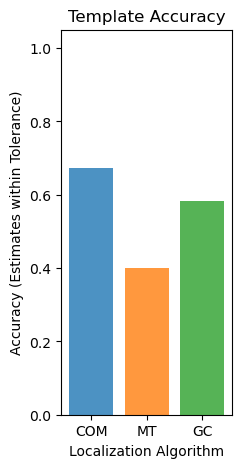

In [7]:
"""Figure 2: Template Accuracy with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method_i, method in enumerate(methods):

    # Compute accuracy for the templates
    n_right = 0
    n_wrong = 0

    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):
        
        loc_est_units, time_units, loc_est_spikes, time_spikes = get_run_params(dead_indices_seed)
        for spe1_cell in spe1_cells:

            # Find the real location
            spe1_closest_electrode = data_summary.loc[data_summary['Cell']==spe1_cell, 'chan_predicted'].iloc[0]
            unit_loc_true = locations[spe1_closest_electrode, :].reshape(1,2)
            unit_loc_true = np.concatenate((np.array([0]).reshape(1,1), unit_loc_true), axis=1)

            # Retrieve the estimated location of templates
            unit_loc_est = loc_est_units[method][spe1_cell]
            
            # Check if the estimated location is within a radius of the real location
            if np.linalg.norm(unit_loc_est[0][:, :2] - unit_loc_true[0][1:]) < correct_radius:
                n_right += 1
            else:
                n_wrong += 1

    # Plot the loss
    loss.append(n_right / (n_right + n_wrong))

ax.bar(fig_method_label, loss, color=colors, alpha=0.8)
ax.title.set_text(f'Template Accuracy')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
fig.savefig(f'{output_spe1}/2A_1.svg', format='svg', bbox_inches='tight')


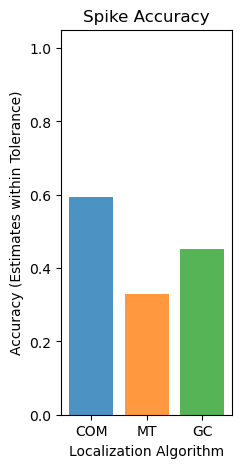

In [8]:
"""Figure 2: Spike Accuracy with No Dead Electrodes"""

loss = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))    

for method in methods:
    
    n_right = 0
    n_wrong = 0
    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):

        loc_est_units, time_units, loc_est_spikes, time_spikes = get_run_params(dead_indices_seed)
        for spe1_cell in spe1_cells:
            
            # Find real location
            spe1_closest_electrode = data_summary.loc[data_summary['Cell']==spe1_cell, 'chan_predicted'].iloc[0]
            unit_loc_true = locations[spe1_closest_electrode, :].reshape(1,2)
            unit_loc_true = np.concatenate((np.array([0]).reshape(1,1), unit_loc_true), axis=1)

            # Retrieve estimated spike locations
            unit_loc_est = loc_est_spikes[method][spe1_cell][0]

            # Calculate loss
            unit_loc_est = unit_loc_est[0] # from list
            unit_loc_est = unit_loc_est[0] # one key

            unit_n_right = 0
            unit_n_wrong = 0
            for spike_loc_est in unit_loc_est:
                spike_loc_est = np.array(spike_loc_est.tolist())[:2]
                if np.linalg.norm(spike_loc_est - unit_loc_true[0][1:]) < correct_radius:
                    unit_n_right += 1
                else:
                    unit_n_wrong += 1
            n_right += unit_n_right
            n_wrong += unit_n_wrong

    loss.append(n_right / (n_right + n_wrong))

ax.bar(fig_method_label, loss, color=colors, alpha=0.8)
ax.title.set_text(f'Spike Accuracy')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
fig.savefig(f'{output_spe1}/2B_1.svg', format='svg', bbox_inches='tight')

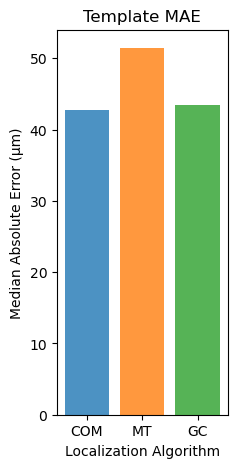

In [9]:
"""Figure 2: Template Median Absolute Error with No Dead Electrodes"""

mae_values = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))

for method_i, method in enumerate(methods):
    all_error_values = []
    
    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):
        
        loc_est_units, time_units, loc_est_spikes, time_spikes = get_run_params(dead_indices_seed)
        for spe1_cell in spe1_cells:
            
            # Find the real location
            spe1_closest_electrode = data_summary.loc[data_summary['Cell']==spe1_cell, 'chan_predicted'].iloc[0]
            unit_loc_true = locations[spe1_closest_electrode, :].reshape(1,2)
            
            # Get estimated location for D0 (day 0)
            loc_est_unit = loc_est_units[method][spe1_cell][0]
            
            # Calculate absolute error using only first 2 dimensions (x, y coordinates)
            absolute_error = np.linalg.norm(loc_est_unit[:, :2] - unit_loc_true, axis=1)
            
            # Add all errors from this template
            all_error_values.extend(absolute_error)
    
    # Calculate median of all absolute error values for this method
    mae_values.append(np.median(all_error_values))

ax.bar(fig_method_label, mae_values, color=colors, alpha=0.8)
ax.set_title('Template MAE')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Median Absolute Error (μm)')

fig.savefig(f'{output_spe1}/2A_2.svg', format='svg', bbox_inches='tight')
plt.show()

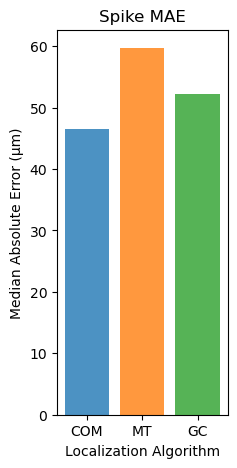

In [10]:
"""Figure: Spike Median Absolute Error with No Dead Electrodes"""

mae_values = []
fig, ax = plt.subplots(1, 1, figsize=(2.2, 5))

for method_i, method in enumerate(methods):
    all_error_values = []
    
    for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):
        
        loc_est_units, time_units, loc_est_spikes, time_spikes = get_run_params(dead_indices_seed)
        for spe1_cell in spe1_cells:
            
            # Find the real location
            spe1_closest_electrode = data_summary.loc[data_summary['Cell']==spe1_cell, 'chan_predicted'].iloc[0]
            unit_loc_true = locations[spe1_closest_electrode, :].reshape(1,2)
            
            # Get estimated spike locations for D0 (day 0)
            loc_est_spike = loc_est_spikes[method][spe1_cell][0]
            
            # Extract spike locations (similar to your existing spike accuracy code)
            unit_loc_est = loc_est_spike[0][0]  # from list and one key
            
            # Calculate absolute error for each spike using only first 2 dimensions (x, y coordinates)
            for spike_loc_est in unit_loc_est:
                spike_loc_est = np.array(spike_loc_est.tolist())[:2]
                absolute_error = np.linalg.norm(spike_loc_est - unit_loc_true.flatten())
                all_error_values.append(absolute_error)
    
    # Calculate median of all absolute error values for this method
    mae_values.append(np.median(all_error_values))

ax.bar(fig_method_label, mae_values, color=colors, alpha=0.8)
ax.set_title('Spike MAE')
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Median Absolute Error (μm)')

fig.savefig(f'{output_spe1}/2B_2.svg', format='svg', bbox_inches='tight')
plt.show()

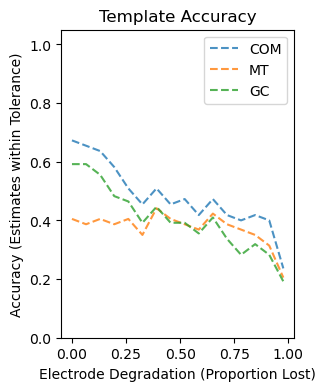

In [11]:
"""Figure 4: Template Accuracy v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
for method_i, method in enumerate(methods):

    # Compute accuracy for the templates
    loss = []
    
    for day_i, day in enumerate(days):
        
        if day in fig_days:

            n_right = 0
            n_wrong = 0
            for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):
                
                loc_est_units, time_units, loc_est_spikes, time_spikes = get_run_params(dead_indices_seed)            
                for spe1_cell in spe1_cells:

                    # Find the real location
                    spe1_closest_electrode = data_summary.loc[data_summary['Cell']==spe1_cell, 'chan_predicted'].iloc[0]
                    unit_loc_true = locations[spe1_closest_electrode, :].reshape(1,2)
                    unit_loc_true = np.concatenate((np.array([0]).reshape(1,1), unit_loc_true), axis=1)

                    # Retrieve the estimated location of templates
                    unit_loc_est = loc_est_units[method][spe1_cell]
                    
                    # Check if the estimated location is within a radius of the real location
                    if np.linalg.norm(unit_loc_est[day_i][:, :2] - unit_loc_true[0][1:]) < correct_radius:
                        n_right += 1
                    else:
                        n_wrong += 1

            loss.append(n_right / (n_right + n_wrong))

    # Plot the loss
    loss = np.array(loss)
    method_jit = method_i * 0.005
    ax.plot(fig_days_label, loss + method_jit, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Template Accuracy')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
ax.legend()

fig.savefig(f'{output_spe1}/4A_1.svg', format='svg', bbox_inches='tight')

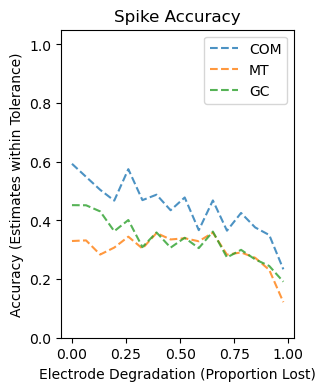

In [12]:
"""Figure 4: Spike Accuracy v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))

for method_i, method in enumerate(methods):

    loss = []
    for day_i, day in enumerate(days):
        
        if day in fig_days:

            n_right = 0
            n_wrong = 0
            for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):
                
                loc_est_units, time_units, loc_est_spikes, time_spikes = get_run_params(dead_indices_seed)
                for spe1_cell in spe1_cells:
                    
                    # Find real location
                    spe1_closest_electrode = data_summary.loc[data_summary['Cell']==spe1_cell, 'chan_predicted'].iloc[0]
                    unit_loc_true = locations[spe1_closest_electrode, :].reshape(1,2)
                    unit_loc_true = np.concatenate((np.array([0]).reshape(1,1), unit_loc_true), axis=1)

                    # Retrieve estimated spike locations
                    unit_loc_est = loc_est_spikes[method][spe1_cell][day_i]

                    # Calculate loss
                    unit_loc_est = unit_loc_est[0] # from list
                    unit_loc_est = unit_loc_est[0] # one key

                    unit_n_right = 0
                    unit_n_wrong = 0
                    for spike_loc_est in unit_loc_est:
                        spike_loc_est = np.array(spike_loc_est.tolist())[:2]
                        if np.linalg.norm(spike_loc_est - unit_loc_true[0][1:]) < correct_radius:
                            unit_n_right += 1
                        else:
                            unit_n_wrong += 1
                    n_right += unit_n_right
                    n_wrong += unit_n_wrong

            loss.append(n_right / (n_right + n_wrong))

    # Create plot
    ax.plot(fig_days_label, loss, linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text(f'Spike Accuracy')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Accuracy (Estimates within Tolerance)')
ax.set_ylim([0, 1.05])
ax.legend()

fig.savefig(f'{output_spe1}/4B_1.svg', format='svg', bbox_inches='tight')

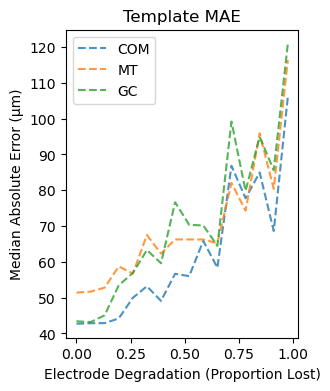

In [13]:
"""Figure 4: Template Median Absolute Error v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
estimated_mae_median = {}

for method_i, method in enumerate(methods):
    estimated_mae_median[method] = np.zeros(len(fig_days_label))
    
    # For each day, collect all absolute error values across all templates and runs
    for day_index, day in enumerate(fig_days):
        all_error_values = []
        
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):
            
            loc_est_units, time_units, loc_est_spikes, time_spikes = get_run_params(dead_indices_seed)    
            for spe1_cell in spe1_cells:
                
                # Find the real location
                spe1_closest_electrode = data_summary.loc[data_summary['Cell']==spe1_cell, 'chan_predicted'].iloc[0]
                unit_loc_true = locations[spe1_closest_electrode, :].reshape(1,2)
                
                # Get estimated location for this day
                day_i = days.index(day)
                loc_est_unit = loc_est_units[method][spe1_cell][day_i]
                
                # Calculate absolute error using only first 2 dimensions (x, y coordinates)
                absolute_error = np.linalg.norm(loc_est_unit[:, :2] - unit_loc_true, axis=1)
                
                # Add all errors from this template (in case there are multiple estimates)
                all_error_values.extend(absolute_error)
        
        # Calculate median of all absolute error values for this day
        estimated_mae_median[method][day_index] = np.median(all_error_values)

# Create a line plot of the median absolute error for all three localization methods
for method_i, method in enumerate(methods):
    ax.plot(fig_days_label, estimated_mae_median[method], linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.set_title('Template MAE')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Median Absolute Error (μm)')
ax.legend()

fig.savefig(f'{output_spe1}/4A_2.svg', format='svg', bbox_inches='tight')
plt.show()

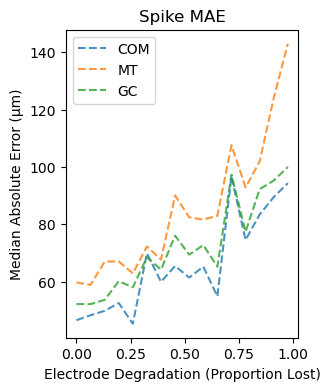

In [14]:
"""Figure 4: Spike Median Absolute Error v. Dead Electrodes"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
estimated_mae_median = {}

for method_i, method in enumerate(methods):
    estimated_mae_median[method] = np.zeros(len(fig_days_label))
    
    # For each day, collect all absolute error values across all spikes and runs
    for day_index, day in enumerate(fig_days):
        all_error_values = []
        
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):
            
            loc_est_units, time_units, loc_est_spikes, time_spikes = get_run_params(dead_indices_seed)    
            for spe1_cell in spe1_cells:
                
                # Find the real location
                spe1_closest_electrode = data_summary.loc[data_summary['Cell']==spe1_cell, 'chan_predicted'].iloc[0]
                unit_loc_true = locations[spe1_closest_electrode, :].reshape(1,2)
                
                # Get estimated spike locations for this day
                day_i = days.index(day)
                loc_est_spike = loc_est_spikes[method][spe1_cell][day_i]
                
                # Extract spike locations
                unit_loc_est = loc_est_spike[0][0]  # from list and one key
                
                # Calculate absolute error for each spike using only first 2 dimensions (x, y coordinates)
                for spike_loc_est in unit_loc_est:
                    spike_loc_est = np.array(spike_loc_est.tolist())[:2]
                    absolute_error = np.linalg.norm(spike_loc_est - unit_loc_true.flatten())
                    all_error_values.append(absolute_error)
        
        # Calculate median of all absolute error values for this day
        estimated_mae_median[method][day_index] = np.median(all_error_values)

# Create a line plot of the median absolute error for all three localization methods
for method_i, method in enumerate(methods):
    ax.plot(fig_days_label, estimated_mae_median[method], linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.set_title('Spike MAE')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Median Absolute Error (μm)')
ax.legend()

fig.savefig(f'{output_spe1}/4B_2.svg', format='svg', bbox_inches='tight')

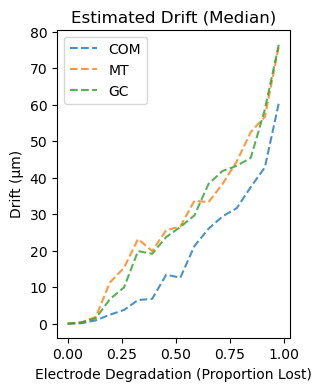

In [15]:
"""Figure 4: Template Drift"""

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
estimated_drift_median = {}

for method_i, method in enumerate(methods):
    estimated_drift_median[method] = np.zeros(len(fig_days_label))
    
    # For each day, collect all drift values across all templates and runs
    for day_index, day in enumerate(fig_days):
        all_drift_values = []
        
        for dead_indices_seed_i, dead_indices_seed in enumerate(dead_indices_seeds):
            
            loc_est_units, time_units, loc_est_spikes, time_spikes = get_run_params(dead_indices_seed)    
            for spe1_cell in spe1_cells:
                
                loc_est_unit_0 = loc_est_units[method][spe1_cell][0]
                day_i = days.index(day)
                loc_est_unit = loc_est_units[method][spe1_cell][day_i]
                
                # Calculate drift using only first 2 dimensions (x, y coordinates)
                drift = np.linalg.norm(loc_est_unit[:, :2] - loc_est_unit_0[:, :2])
                all_drift_values.append(drift)
        
        # Calculate median of all drift values for this day
        estimated_drift_median[method][day_index] = np.median(all_drift_values)

# Create a line plot of the median drift for all three localization methods
for method_i, method in enumerate(methods):
    ax.plot(fig_days_label, estimated_drift_median[method], linestyle='--', label=fig_method_label[method_i], alpha=0.8)

ax.title.set_text('Estimated Drift (Median)')
ax.set_xlabel('Electrode Degradation (Proportion Lost)')
ax.set_ylabel('Drift (μm)')
ax.legend()

fig.savefig(f'{output_spe1}/4A_3.svg', format='svg', bbox_inches='tight')

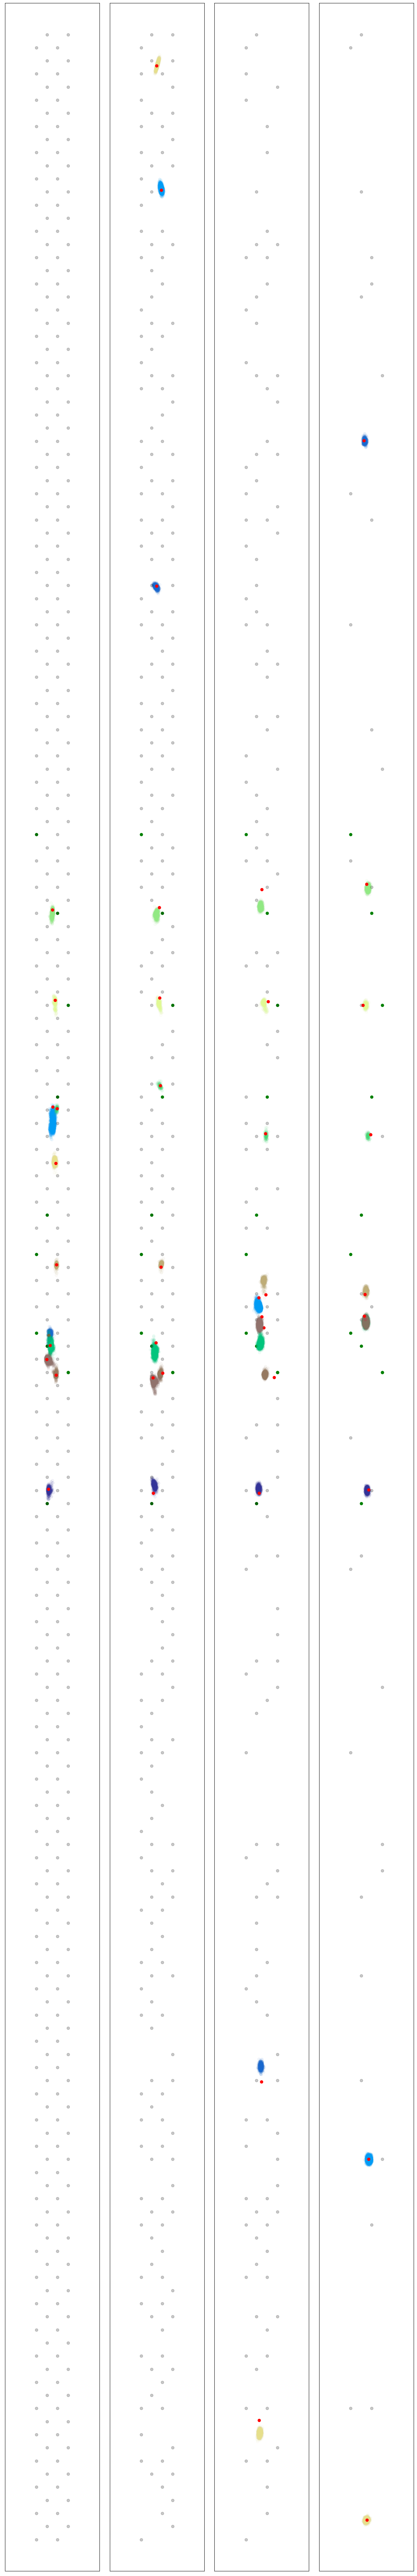

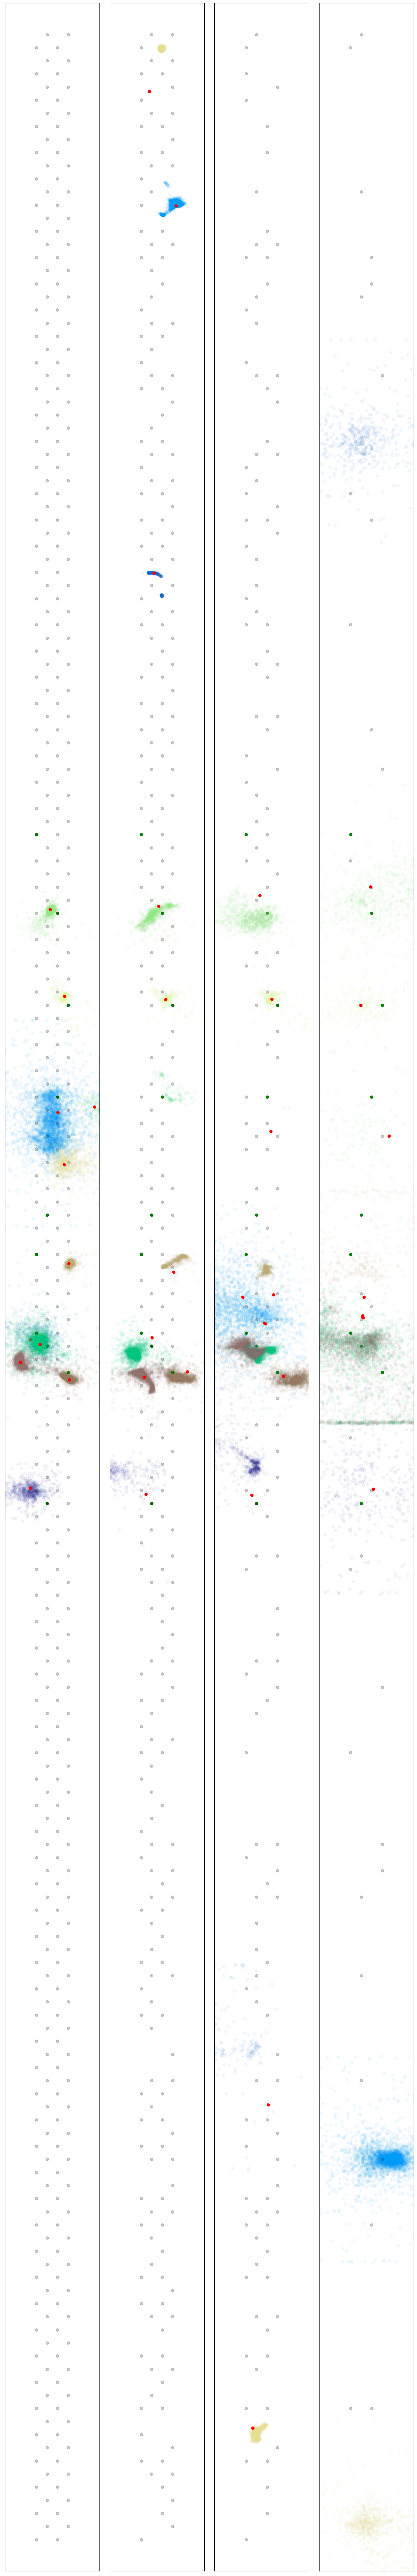

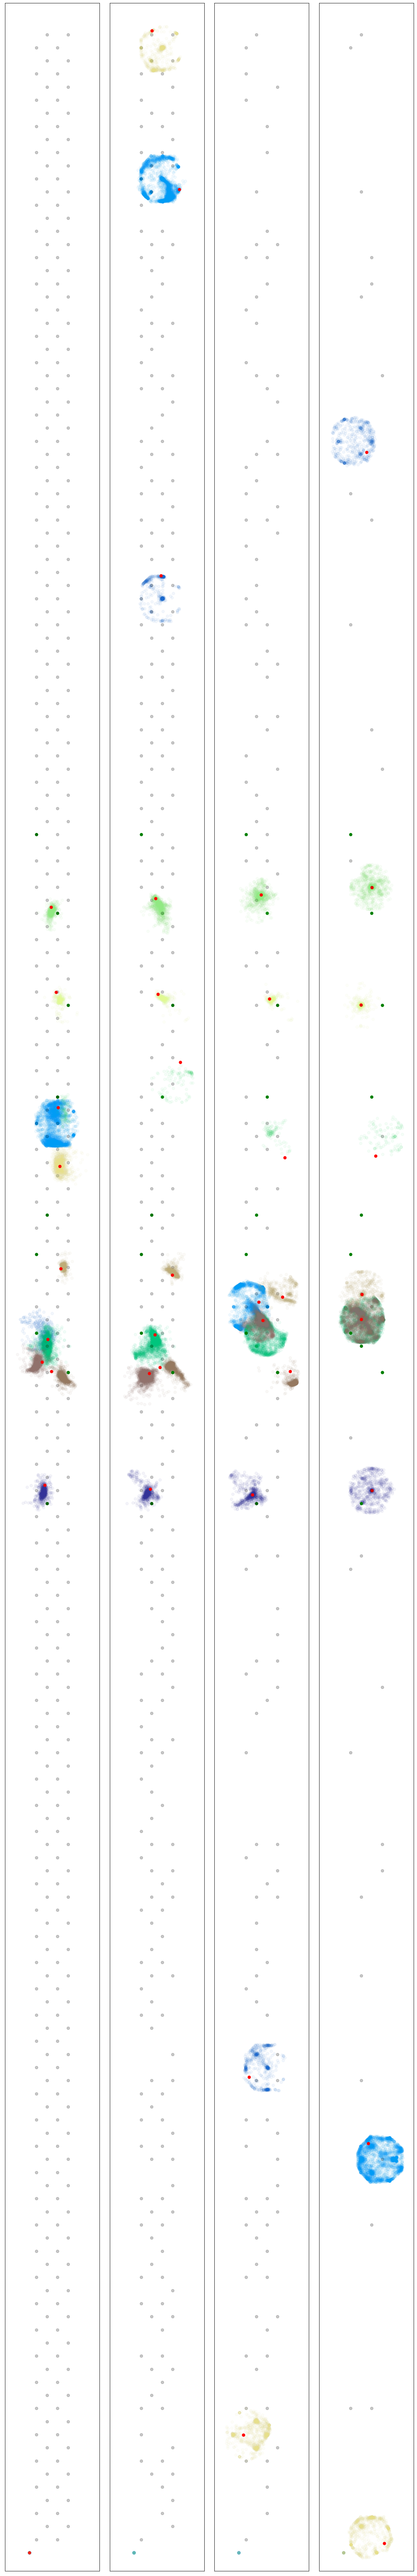

In [16]:
fig_days_2 = ['D0', 'D5', 'D10', 'D15']

output_spe1_seed = f'{output_spe1}/seed_{42}'
loc_est_units, time_units, loc_est_spikes, time_spikes = get_run_params(42)
with open(f'{output_spe1_seed}/dead_indices.pkl', 'rb') as f:
    dead_indices = pickle.load(f)

for method in methods:

    col_num = 4
    fig, axs = plt.subplots(1, col_num, figsize=(4*col_num, 100))  # Adjusted height for single row
    plt.subplots_adjust(wspace=0.05)

    range_x = locations[:, 0].max() - locations[:, 0].min()
    range_y = locations[:, 1].max() - locations[:, 1].min()
    range_A = min(range_x, range_y)

    for day_i, day in enumerate(days):

        if day in fig_days_2:

            for spe1_cell_i, spe1_cell in enumerate(spe1_cells):
                
                # Find real location
                closest_electrode = data_summary.loc[data_summary['Cell']==spe1_cell, 'chan_predicted'].iloc[0]
                unit_loc_true = locations[closest_electrode, :].reshape(1,2)
                unit_loc_true = np.concatenate((np.array([0]).reshape(1,1), unit_loc_true), axis=1)

                # Retrieve the estimated location of the spikes
                loc_est_spike = loc_est_spikes[method][spe1_cell][day_i]
                loc_est_unit = loc_est_units[method][spe1_cell][day_i]

                dead_electrodes = dead_indices[day_i]
                live_electrodes = np.delete(np.arange(locations.shape[0]), dead_electrodes)

                # Plot - simplified indexing for single row
                col_gt = fig_days_2.index(day)  # Direct column index since we know the order

                unit_loc_est_temp = loc_est_spike[0][0]
                unit_loc_est_temp = np.array(unit_loc_est_temp.tolist())
                axs[col_gt].scatter(unit_loc_est_temp[:, 0], unit_loc_est_temp[:, 1], color=plt.get_cmap('terrain')(spe1_cell_i*20), alpha=0.05, label='Estimated Spikes', rasterized=True)
                
                axs[col_gt].scatter(locations[live_electrodes, 0], locations[live_electrodes, 1], color=[0, 0, 0], alpha=0.02 , label='Electrodes')
                axs[col_gt].scatter(loc_est_unit[:, 0], loc_est_unit[:, 1], color='red', label='Estimated Templates')
                axs[col_gt].scatter(unit_loc_true[:, 1], unit_loc_true[:, 2], color='green', label='True Neurons')
                axs[col_gt].set_xlim([locations[:, 0].min() - range_A*1.0, locations[:, 0].max() + range_A*1.0])
                axs[col_gt].set_ylim([locations[:, 1].min() - range_A*1.0, locations[:, 1].max() + range_A*1.0])
                axs[col_gt].get_xaxis().set_visible(False)
                axs[col_gt].get_yaxis().set_visible(False)
                axs[col_gt].set_aspect('equal')

    fig.savefig(f'{output_spe1}/4C_{method}.svg', format='svg', bbox_inches='tight')

## Refresh data

In [17]:
import importlib
import src

importlib.reload(src.util_eval)
from src.util_eval import *